In [11]:
import pandas as pd
import codecs as cd
path_to_media = './data/extra_infos.json'
path_to_train = './data/train.csv'

In [12]:
# read the entire file into a python array
with cd.open(path_to_media, 'r', 'utf-8') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

data_json_str = "[" + ','.join(data) + "]"

media_info = pd.read_json(data_json_str)
media_info.head()

,alb_title,art_name,media_id,sng_title
0,El Son de Cuba,Septeto Nacional De Ignacio Pineiro,213952,Maria Cristina
1,Sounds from the fourth world,Calvin Russell,223014,Love stealer
2,Le meilleur de Malavoi,Malavoi,237198,Caressé moin
3,Les titres essentiels Cuba,Soneros De Verdad,238380,A Buena Vista
4,Dantzig Twist,Marquis de Sade,244881,Nacht und Nebel


In [14]:
train = pd.read_csv(path_to_train, encoding='utf-8', nrows=2000)
train.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


Є три типи колонок. Є інформація про користувача: `user_gender`, `user_age`. Є інформація про пісню: назва, альбом, виконавець, `genre_id`, `release_date`, `media_duration`. Є інформація про конкретне прослуховування: `ts_listen`, `platform_name`, `platform_family`, `listen_type`.

Що звідки ми можемо витягнути? Час доби. Чи слухає користувач flow взагалі. 

Як можна кластеризувати користувачів? Скільки разів він слухав кожен з жанрів (порахувати кількість жанрів). В який час любить слухати музику (вечір, робочий час, вихідні). В якому контексті скільки разів він слухав музику. З якої платформи скільки разів він слухав музику. Чи використовує він Flow. І, найскладніше, за спільними музичними уподобаннями.

Для останнього можна спробувати аналіз графа.

#### Питання 1
Чи є розшифровка закодованних полів? (`platform_name`, `platform_family` etc)

#### Feature idea 1 (+++)
Можна з назви пісні, альбома, імені виконавця витащити мову, на якій ця пісня. 100% це буде важлива фіча.
#### Feature idea 2 (+)
Можна взяти як фічу час доби.
#### Feature idea 3 (++++++)
Порівнювати музику за допомогою DBPedia https://link.springer.com/chapter/10.1007%2F978-3-642-13489-0_34?LI=true
#### Feature idea 4 (++)
Побудувати граф по цих данних і визначати відстань від пісні до користувача.
#### Feature idea 5 (+++++)
Витащити з DBPedia жанри цих пісень і натренувати нейронку визначати жанр. Потім дані з останнього шару нейронки використовувати як фічі.

In [15]:
train = pd.read_csv(path_to_train, encoding='utf-8')

In [16]:
train.describe()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
count,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06,7.558834e+06
mean,2.245030e+03,1.479011e+09,7.839624e+07,8.136169e+06,2.360018e+00,2.011388e+07,4.731900e-01,2.558086e-01,2.311527e+02,3.068742e-01,3.936884e-01,4.037300e+03,1.500740e+06,2.431278e+01,6.840330e-01
std,1.308979e+04,1.189935e+07,5.133633e+07,5.460090e+06,4.659856e+00,7.570138e+04,7.353008e-01,5.481663e-01,7.999463e+01,4.611968e-01,4.885672e-01,3.954754e+03,2.519546e+06,3.767797e+00,4.648999e-01
min,0.000000e+00,1.000000e+00,2.000580e+05,1.976000e+03,0.000000e+00,1.900010e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.800000e+01,0.000000e+00
25%,0.000000e+00,1.478460e+09,1.376614e+07,1.255566e+06,0.000000e+00,2.009123e+07,0.000000e+00,0.000000e+00,1.960000e+02,0.000000e+00,0.000000e+00,8.990000e+02,2.605000e+03,2.100000e+01,0.000000e+00
50%,3.000000e+00,1.479057e+09,9.380660e+07,9.525626e+06,1.000000e+00,2.014103e+07,0.000000e+00,0.000000e+00,2.220000e+02,0.000000e+00,0.000000e+00,2.738000e+03,1.941720e+05,2.500000e+01,1.000000e+00
75%,2.700000e+01,1.479742e+09,1.262592e+08,1.329221e+07,2.000000e+00,2.016061e+07,1.000000e+00,0.000000e+00,2.540000e+02,1.000000e+00,1.000000e+00,6.064000e+03,1.519461e+06,2.800000e+01,1.000000e+00
max,2.597310e+05,1.480636e+09,1.372601e+08,1.472086e+07,7.300000e+01,3.000010e+07,2.000000e+00,2.000000e+00,6.553500e+04,1.000000e+00,1.000000e+00,1.991700e+04,1.144741e+07,3.000000e+01,1.000000e+00


In [19]:
len(train["genre_id"].unique())

2922

In [20]:
len(train["context_type"].unique()) # цікаво, що це за контексти?

74

In [21]:
len(train["platform_name"].unique()) # PC, smartphone, tablet?

3

In [22]:
len(train["platform_family"].unique()) # Windows, android, iOS?

3

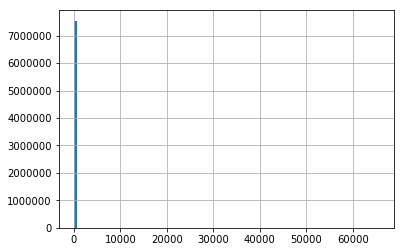

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
train["media_duration"].hist(bins=100)

Дуже дивно виглядає `media_duration`, наче є якісь супер аутлаєри. Може це якісь аудіо книги?

In [27]:
train["media_duration"].describe() 

count    7.558834e+06
mean     2.311527e+02
std      7.999463e+01
min      0.000000e+00
25%      1.960000e+02
50%      2.220000e+02
75%      2.540000e+02
max      6.553500e+04
Name: media_duration, dtype: float64

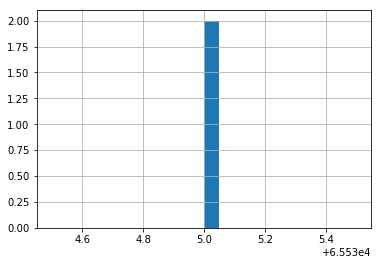

In [41]:
limit = 10000
outliers = train[train['media_duration'] > limit]
outliers['media_duration'].hist(bins=20)

In [40]:
limit

446.0

In [42]:
outliers['media_duration']

4243646    65535
5079844    65535
Name: media_duration, dtype: int64